# Hyperparams and Helpers

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz

--2021-10-26 17:19:48--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.204.104
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.204.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.3MB/s    in 99s     

2021-10-26 17:21:28 (15.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [46]:
import cv2
import numpy as np
import pickle
import os
import itertools

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors
import random
from sklearn.model_selection import train_test_split
random.seed(517)

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [ ]:
# Global Path Vairables
ROOT_DIR =  "drive/MyDrive/DecorAssist/"
DATASET_DIR = ROOT_DIR + "IKEA/text_data/"
IMAGES_DIR = ROOT_DIR + "IKEA/images/all_items/"

# Global Parameter Variables
MAX_SEQUENCE_LENGTH = 100
NUM_WORDS_TOKENIZER = 50000
EMBEDDING_DIM = 300
BATCH_SIZE = 16
POSITIVE_SIZE = 300 # We might only use a subset of the positive pairs
TRAIN_TEST_RATIO = 0.33

# Model Hyperparameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-4 # 0.001
HIDDEN_DIM = 128 # 64
N_LAYERS = 4 # 2
EPOCHS = 10
CLIP = 5

In [ ]:
def preprocess_img(path):
  img = cv2.imread(path)
  img = cv2.resize(img, (75, 115))
  img = img.astype(np.float32) / 255
  return img


def read_pickle(fn):
	with open(fn, "rb") as f:
		return pickle.load(f)
  

def random_negative_sampling(all_positive_pairs):
  num_examples = len(all_positive_pairs) * 2
  all_item_ids = list(set([x[0] for x in all_positive_pairs] + [x[1] for x in all_positive_pairs]))
  negative_count = 0
  selected_negative_pairs = []
  while negative_count < num_examples / 2:
    random_pair = tuple(random.sample(all_item_ids, 2))
    if random_pair in all_positive_pairs:
      continue
    else:
      selected_negative_pairs.append(random_pair)
      negative_count += 1
  return selected_negative_pairs


def get_embedding_matrix(word_index, weights_path="/content/GoogleNews-vectors-negative300.bin"):
  word2vecDict = KeyedVectors.load_word2vec_format(weights_path, binary=True)
  embed_size = 300
  embeddings_index = dict()
  for word in word2vecDict.wv.vocab:
    embeddings_index[word] = word2vecDict.word_vec(word)
  print("Loaded " + str(len(embeddings_index)) + " word vectors.")
        
  embedding_matrix = 1 * np.random.randn(len(word_index)+1, embed_size)

  embeddedCount = 0
  for word, i in word_index.items():
    i-=1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector
      embeddedCount+=1
  print("total embedded:", embeddedCount, "common words")
  del(embeddings_index)
  return embedding_matrix

# Build Train and Eval Set

#### Load raw data

In [ ]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

# Some simple preprossing
item_to_info = {key : value["type"] + " " +
                             value["desc"]
                       for key, value in item_property.items()} # remove view more info

room_to_items = {}

for item_url, room_url_list in item_to_rooms_map.items():
  item_id = item_url.split("/")[-1].split(".jpg")[0]

  for room_url in room_url_list:
    room_id = room_url.split("/")[-1].split(".jpg")[0]
    if room_id not in room_to_items:
      room_to_items[room_id] = []
    else:
      room_to_items[room_id].append(item_id)

#### Construct positive and negative pairs

For IR-style problem, seen and unseen can be tricky. We need to discuss whether unseen means "unseen pairs" or "unseen image or text"

In [ ]:
all_positive_pairs = []
for room, item_id_list in room_to_items.items():
  pairs_for_current_room = list(itertools.combinations(room_to_items[room], 2)) # n choose 2
  all_positive_pairs += pairs_for_current_room

all_positive_pairs = all_positive_pairs[:POSITIVE_SIZE]
all_pairs = all_positive_pairs + random_negative_sampling(all_positive_pairs)
y = np.array([np.array([1, 0]) for _ in range(len(all_positive_pairs))] + 
             [np.array([0, 1]) for _ in range(len(all_positive_pairs))])
train_pairs, val_paris, y_train, y_val = train_test_split(all_pairs, y, test_size=TRAIN_TEST_RATIO, random_state=517)

#### Build PyTorch dataloader for train/val image/text

In [ ]:
train_image_premise_id_list = [x[0] for x in train_pairs]
train_image_hypothesis_id_list = [x[1] for x in train_pairs]
X_train_image_premise = np.array(list(map(lambda image_id: preprocess_img(IMAGES_DIR + image_id + ".jpg"), train_image_premise_id_list)))
X_train_image_hypothesis = np.array(list(map(lambda image_id: preprocess_img(IMAGES_DIR + image_id + ".jpg"), train_image_hypothesis_id_list)))
X_train_image_premise = np.reshape(X_train_image_premise, (X_train_image_premise.shape[0], 3, 75, 115))
X_train_image_hypothesis = np.reshape(X_train_image_hypothesis, (X_train_image_hypothesis.shape[0], 3, 75, 115))

In [ ]:
val_image_premise_id_list = [x[0] for x in val_paris]
val_image_hypothesis_id_list = [x[1] for x in val_paris]
X_val_image_premise = np.array(list(map(lambda image_id: preprocess_img(IMAGES_DIR + image_id + ".jpg"), val_image_premise_id_list)))
X_val_image_hypothesis = np.array(list(map(lambda image_id: preprocess_img(IMAGES_DIR + image_id + ".jpg"), val_image_hypothesis_id_list)))
X_val_image_premise = np.reshape(X_val_image_premise, (X_val_image_premise.shape[0], 3, 75, 115))
X_val_image_hypothesis = np.reshape(X_val_image_hypothesis, (X_val_image_hypothesis.shape[0], 3, 75, 115))

In [ ]:
train_premise_texts = [item_to_info[id] for id in train_image_premise_id_list]
train_hypothesis_texts = [item_to_info[id] for id in train_image_hypothesis_id_list]
tokenizer = Tokenizer(num_words=NUM_WORDS_TOKENIZER, lower=True)
tokenizer.fit_on_texts(train_premise_texts + train_hypothesis_texts)
WORD_INDEX = tokenizer.word_index
print('Found %s unique tokens.' % len(WORD_INDEX))
print('Max len:', MAX_SEQUENCE_LENGTH)
WORD2VEC_EMBEDDING_MATRIX = get_embedding_matrix(WORD_INDEX)

X_train_text_premise = tokenizer.texts_to_sequences(train_premise_texts)
X_train_text_premise = pad_sequences(X_train_text_premise, maxlen=MAX_SEQUENCE_LENGTH)

X_train_text_hypothesis = tokenizer.texts_to_sequences(train_hypothesis_texts)
X_train_text_hypothesis = pad_sequences(X_train_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH)

Found 288 unique tokens.
Max len: 100
Loaded 3000000 word vectors.
total embedded: 272 common words


In [ ]:
val_premise_texts = [item_to_info[id] for id in val_image_premise_id_list]
val_hypothesis_texts = [item_to_info[id] for id in val_image_hypothesis_id_list]

# Please notice that: tokenizer is ONLY used on training set to build vocab
X_val_text_premise = tokenizer.texts_to_sequences(val_premise_texts)
X_val_text_premise = pad_sequences(X_val_text_premise, maxlen=MAX_SEQUENCE_LENGTH)

X_val_text_hypothesis = tokenizer.texts_to_sequences(val_hypothesis_texts)
X_val_text_hypothesis = pad_sequences(X_val_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
img_train_data = TensorDataset(torch.from_numpy(X_train_image_premise), torch.from_numpy(X_train_image_hypothesis), torch.from_numpy(y_train))
text_train_data = TensorDataset(torch.from_numpy(X_train_text_premise), torch.from_numpy(X_train_text_hypothesis), torch.from_numpy(y_train))

img_val_data = TensorDataset(torch.from_numpy(X_val_image_premise), torch.from_numpy(X_val_image_hypothesis), torch.from_numpy(y_val))
text_val_data = TensorDataset(torch.from_numpy(X_val_text_premise), torch.from_numpy(X_val_text_hypothesis), torch.from_numpy(y_val))

text_train_loader = DataLoader(text_train_data, batch_size=BATCH_SIZE)
img_train_loader = DataLoader(img_train_data, batch_size=BATCH_SIZE)

text_val_loader = DataLoader(text_val_data, batch_size=BATCH_SIZE)
img_val_loader = DataLoader(img_val_data, batch_size=BATCH_SIZE)

print(len(text_train_loader), len(img_train_loader))
print(len(text_val_loader), len(img_val_loader))

26 26
13 13


# Define Model

In [35]:
class CNN_LSTM(nn.Module):
  def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out):
    super(CNN_LSTM, self).__init__()

    # LSTM for the text overview
    self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    self.emb = nn.Embedding(num_embeddings, embedding_dim)
    self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
    self.emb.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.dropout = nn.Dropout(0.1)
    self.lstm_fc = nn.Linear(self.n_hidden, 128)
    # self.sigmoid = nn.Sigmoid()

    # CNN for the posters
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.max_pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.max_pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.max_pool3 = nn.MaxPool2d(2)
    self.conv4 = nn.Conv2d(128, 128, 3)
    self.max_pool4 = nn.MaxPool2d(2)
    self.cnn_dropout = nn.Dropout(0.1)
    self.cnn_fc = nn.Linear(5*2*128, 512)

    # Concat layer for the combined feature space
    # self.combined_fc1 = nn.Linear(640, 256)
    self.combined_fc1 = nn.Linear(640*2, 256)
    self.combined_fc2 = nn.Linear(256, 128)
    self.output_fc = nn.Linear(128, n_out)
    self.softmax = nn.Softmax()

  def lstm_encoder(self, lstm_inp):
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))
    return lstm_out

  def cnn_encoder(self, cnn_inp):
    x = F.relu(self.conv1(cnn_inp))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = F.relu(self.conv3(x))
    x = self.max_pool3(x)
    x = F.relu(self.conv4(x))
    x = self.max_pool4(x)
    x = x.view(-1, 5 * 2 * 128)
    x = self.cnn_dropout(x)
    cnn_out = F.relu(self.cnn_fc(x))
    return cnn_out

  def forward(self, lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2):
    cnn_out1, cnn_out2 = self.cnn_encoder(cnn_inp1), self.cnn_encoder(cnn_inp2)
    lstm_out1, lstm_out2 = self.lstm_encoder(lstm_inp1), self.lstm_encoder(lstm_inp2)
    combined_inp = torch.cat((cnn_out1, cnn_out2, lstm_out1, lstm_out2), 1)
    x_comb = F.relu(self.combined_fc1(combined_inp))
    x_comb = F.relu(self.combined_fc2(x_comb))
    # out = torch.sigmoid(self.output_fc(x_comb))
    out = self.softmax(self.output_fc(x_comb))
    return out

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
    return hidden

In [36]:
print("Currently using device: {}\n".format(DEVICE))

model = CNN_LSTM(len(WORD_INDEX)+1, WORD2VEC_EMBEDDING_MATRIX, HIDDEN_DIM, N_LAYERS, y.shape[1])
model.to(DEVICE)
print("Model Architecture {}\n".format(model))

lr= LEARNING_RATE
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

print("Training Started...")
model.train()
for i in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
    
  for lstm, cnn in zip(text_train_loader, img_train_loader):
    lstm_inp1, lstm_inp2, lstm_labels = lstm
    cnn_inp1, cnn_inp2, cnn_labels = cnn
    lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.to(DEVICE), lstm_inp2.to(DEVICE), lstm_labels.to(DEVICE)
    cnn_inp1, cnn_inp2, cnn_labels = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE), cnn_labels.to(DEVICE)
    model.zero_grad()
    output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)
    loss = criterion(output.squeeze(), lstm_labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), CLIP)
    optimizer.step()
    
    with torch.no_grad():
      acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_train += acc
      total_loss_train += loss.item()
  
  train_acc = total_acc_train/len(text_train_loader)
  train_loss = total_loss_train/len(text_train_loader)
  model.eval()
  total_acc_val = 0
  total_loss_val = 0
  with torch.no_grad():
    for lstm, cnn in zip(text_val_loader, img_val_loader):
      lstm_inp1, lstm_inp2, lstm_labels = lstm
      cnn_inp1, cnn_inp2, cnn_labels = cnn
      lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.to(DEVICE), lstm_inp2.to(DEVICE), lstm_labels.to(DEVICE)
      cnn_inp1, cnn_inp2, cnn_labels = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE), cnn_labels.to(DEVICE)
      model.zero_grad()
      output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)
      val_loss = criterion(output.squeeze(), lstm_labels.float())
      acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_val += acc
      total_loss_val += val_loss.item()
  val_acc = total_acc_val/len(text_val_loader)
  val_loss = total_loss_val/len(text_val_loader)
  print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
  model.train()
  torch.cuda.empty_cache()

Currently using device: cuda

Model Architecture CNN_LSTM(
  (emb): Embedding(289, 300)
  (lstm): LSTM(300, 128, num_layers=4, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=128, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=1280, out_features=512, bias=True)
  (combined_fc

# Ranker
- For image 1 image 2 text 1 text 2 as input, we generate a score ~(0,1).
- Search engine: only given one image and one text, compute the score for this item with all the other items in the pool. E.g, if we have num_items, the score matrix will be (num_items, ). Find predicted top 5 or top 10.
- Haocheng's ranking evaluation: for a specific item, we know all the ground truth items that are in the same room as this specific item. 

The output from yuanxin: {"802.903.9234.923" : score, xxx}

In [72]:
def single_pair_inference(premise_image_path, hypothesis_image_path, premise_text, hypothesis_text, model, tokenizer, threshold, do_plot=False):
  premise_sequence = tokenizer.texts_to_sequences([premise_text])
  premise_sequence = pad_sequences(premise_sequence, maxlen=MAX_SEQUENCE_LENGTH)
  hypothesis_sequence = tokenizer.texts_to_sequences([hypothesis_text])
  hypothesis_sequence = pad_sequences(hypothesis_sequence, maxlen=MAX_SEQUENCE_LENGTH)
  image_premise, image_hypothesis = preprocess_img(premise_image_path), preprocess_img(hypothesis_image_path)

  if do_plot:
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(image_premise)
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(image_hypothesis)
    print("Left item description ------ {}".format(premise_text))
    print("Right item description ------  {}".format(hypothesis_text))


  image_premise = np.reshape(image_premise, (1, 3, 75, 115))
  image_hypothesis = np.reshape(image_hypothesis, (1, 3, 75, 115))

  img_data = TensorDataset(torch.from_numpy(image_premise), torch.from_numpy(image_hypothesis))
  text_data = TensorDataset(torch.from_numpy(premise_sequence), torch.from_numpy(hypothesis_sequence))
  
  text_loader = DataLoader(text_data, batch_size=1)
  img_loader = DataLoader(img_data, batch_size=1)

  for lstm, cnn in zip(text_loader, img_loader):
    lstm_inp1, lstm_inp2 = lstm
    cnn_inp1, cnn_inp2 = cnn
    lstm_inp1, lstm_inp2 = lstm_inp1.to(DEVICE), lstm_inp2.to(DEVICE)
    cnn_inp1, cnn_inp2 = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE)
    model.zero_grad()
    output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)

  score = output.squeeze().cpu().detach().numpy().tolist()[0]
  if score > threshold:
    return "Positive", score
  else:
    return "Negative", 1 - score


Left item description ------ Children's table 
Right item description ------  Bed storage box Imagine having your own bed storage box that looks like a suitcase with both a handle and an address holder. Perfect for both toys and secrets.
Actual Label for this pair is Positive
The prediction for this pair is Positive with confidence 0.5573071837425232


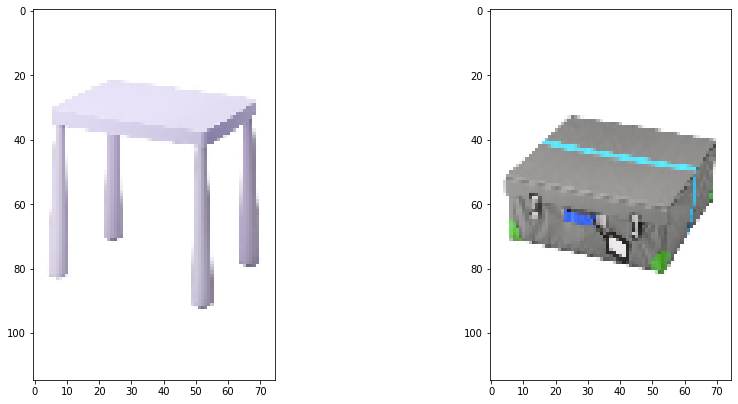

In [73]:
random_index = random.randint(0, len(train_image_premise_id_list))
image_id_1 = train_image_premise_id_list[random_index]
image_id_2 = train_image_hypothesis_id_list[random_index]
text_1 = train_premise_texts[random_index]
text_2 = train_hypothesis_texts[random_index]
prediction, confidence = single_pair_inference(premise_image_path=IMAGES_DIR + image_id_1 + ".jpg",
          hypothesis_image_path=IMAGES_DIR + image_id_2 + ".jpg",
          premise_text=text_1,
          hypothesis_text=text_2,
          model=model,
          tokenizer=tokenizer,
          threshold=0.4,
          do_plot=True)
print("Actual Label for this pair is", "Positive" if y_train[random_index].tolist() == [1, 0] else "Negative")
print("The prediction for this pair is", prediction, "with confidence", confidence)

In [74]:
def ranker(input_image_id, input_description, item_id_pool, model, tokenizer, threshold=0.3, top_n=5, do_plot=False):
  # for id in item_id_pool, get image, get description, input to single_pair_inference
  # 
  input_image_path = IMAGES_DIR + input_image_id + ".jpg"
  item_id_to_score = {}

  for item_id in item_id_pool:
    candidate_image_path = IMAGES_DIR + item_id + ".jpg"
    candidate_description = item_to_info[item_id]
    output_prediction, output_confidence = single_pair_inference(premise_image_path=input_image_path,
          hypothesis_image_path=candidate_image_path,
          premise_text=input_description,
          hypothesis_text=candidate_description,
          model=model,
          tokenizer=tokenizer,
          threshold=threshold,
          do_plot=False)
    if output_prediction == "Positive":
      item_id_to_score[item_id] = output_confidence
    else:
      continue
  return item_id_to_score

In [75]:
random_index = random.randint(0, len(train_image_premise_id_list))
image_id = train_image_premise_id_list[random_index]
input_description = item_to_info[image_id]
all_item_ids = list(set([x[0] for x in all_positive_pairs] + [x[1] for x in all_positive_pairs]))

ranker(image_id, input_description, all_item_ids, model, tokenizer)

{'001.660.95': 0.30868789553642273,
 '003.218.69': 0.3463829755783081,
 '003.288.37': 0.7760784029960632,
 '101.327.88': 0.3226427733898163,
 '102.628.31': 0.6723896861076355,
 '200.474.50': 0.8119797110557556,
 '201.932.67': 0.640713095664978,
 '203.086.97': 0.4446046054363251,
 '203.323.53': 0.8891764283180237,
 '301.933.18': 0.7805899381637573,
 '302.980.23': 0.5240936875343323,
 '303.288.31': 0.7822014093399048,
 '403.288.40': 0.7499198317527771,
 '491.234.05': 0.4542231559753418,
 '501.158.62': 0.5011304616928101,
 '501.711.22': 0.6947008967399597,
 '502.675.58': 0.4075872302055359,
 '502.831.05': 0.5570210218429565,
 '503.323.23': 0.412087082862854,
 '503.334.07': 0.767254114151001,
 '503.334.12': 0.3457525372505188,
 '600.940.72': 0.7108875513076782,
 '603.303.47': 0.3702891170978546,
 '700.914.12': 0.5345611572265625,
 '703.323.55': 0.8891229033470154,
 '802.290.08': 0.3197900950908661,
 '802.538.09': 0.7274831533432007,
 '802.962.48': 0.44906315207481384,
 '803.292.44': 0.6919